## Evaluation of accuracy with EfficientNet-B0 with classifier - 59.27%

In [1]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd
from time import time

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline


In [2]:
PATH = r'D:\Users\amira\openvino_notebooks\notebooks\accuracy_afew\models\enet_b0_8\enet_b0_8.pt'

feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()


EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

Path to directory is organised like DATA_DIR/Val_AFEW/emotion_name/video_name/[images from MTCNN]

In [3]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\AudioVideo\faces+'
IMG_SIZE = 224

emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}
device = 'cuda:0'


In [6]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [10]:
def get_features(data_dir):
    filename2features={}
    for class_name in os.listdir(data_dir):
        if class_name in emotion_to_index:
            class_dir = os.path.join(data_dir, class_name)
        for video_name in tqdm(os.listdir(class_dir)):
            frames_dir=os.path.join(class_dir,video_name)
            X_global_features,X_isface=[],[]
            imgs=[]
            for img_name in os.listdir(frames_dir):
                img = Image.open(os.path.join(frames_dir,img_name))
                img = img.convert('RGB')
                img_tensor = test_transforms(img)
                X_isface.append('noface' not in img_name)
                    
                if img.size:
                    imgs.append(img_tensor)
                    if len(imgs)>=16:        
                        #global_features,feats,scores=feature_extractor_model.predict(inp)
                        scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        scores=scores.data.cpu().numpy()
                        #print(scores.shape)
                
                        #print(global_features.shape,feats.shape,scores.shape)
                        if len(X_global_features)==0:
                            X_global_features=scores
                        else:
                            X_global_features=np.concatenate((X_global_features,scores),axis=0)
                        
                        imgs=[]

            if len(imgs)>0:   
                scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                scores=scores.data.cpu().numpy()
                #print(scores.shape)

                #print(global_features.shape,feats.shape,scores.shape)
                if len(X_global_features)==0:
                    X_global_features=scores
                else:
                    X_global_features=np.concatenate((X_global_features,scores),axis=0)

            X_isface=np.array(X_isface)
            #print(X_global_features.shape,X_feats.shape,X_scores.shape)
            filename2features[video_name]=(X_global_features,X_isface)
    return filename2features

filename2features_val=get_features(os.path.join(DATA_DIR, 'Val_AFEW'))
filename2features_train=get_features(os.path.join(DATA_DIR, 'Train_AFEW'))


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

In [4]:
import pickle
model_name = 'enet_b0_8'
MODEL2EMOTIW_FEATURES=model_name+'_afew_extra.pickle' 

print(MODEL2EMOTIW_FEATURES)


enet_b0_8_afew_extra.pickle


In [12]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)
print(len(filename2features_train),len(filename2features_val))

773 383


In [5]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))


773 383


In [6]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in emotion_to_index:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None

            if len(features[0])!=0:
                cur_features=features[0][features[-1]==1]

            if len(cur_features)==0:
                print(class_name,': ',filename)
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train_enet, y_train_enet, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test_enet, y_test_enet, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [8]:
import pickle
model_name = 'enet_b0'
MODEL2EMOTIW_FEATURES=model_name+'_afew_extra_dataset_test.pickle' 

print(MODEL2EMOTIW_FEATURES)

with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([x_test_enet, y_test_enet, has_faces_test], handle, protocol=pickle.HIGHEST_PROTOCOL)
#print(len(filename2features_train),len(filename2features_val))

enet_b0_afew_extra_dataset_test.pickle


In [7]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train_enet,norm='l2')
x_test_norm=preprocessing.normalize(x_test_enet,norm='l2')

In [10]:
svc_clf = svm.LinearSVC(C=1.1) #0.5 1.1 0.6
#clf = svm.SVC(C=10.0, gamma=1.0, kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    svc_clf.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
    y_pred = svc_clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5926892950391645
Complete accuracy: 0.5926892950391645


Text(159.0, 0.5, 'Actual')

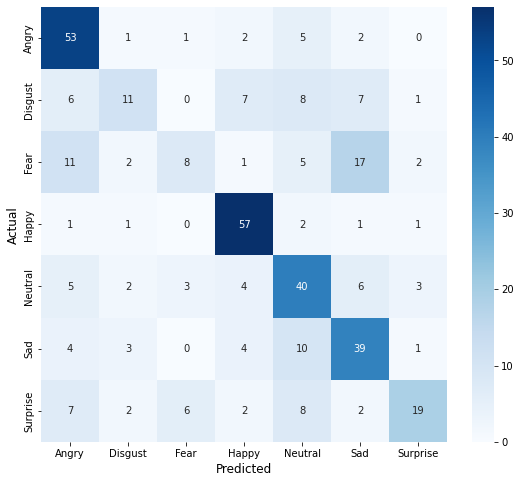

In [22]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')

confusion = pd.crosstab(y_test_enet, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = classes
confusion.index = classes

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
#ax1.set_title('Confusion matrix')
s = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
s.set_xlabel('Predicted', fontsize=12)
s.set_ylabel('Actual', fontsize=12)

In [28]:
#np.random.seed(9)
clf=RandomForestClassifier(bootstrap=False, max_depth=45, max_features='auto', n_estimators=1500, class_weight='balanced',)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)

print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Complete accuracy: 0.5535248041775457


In [29]:
rf_proba = clf.predict_proba(x_test_norm)